In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
import requests
from datetime import datetime, timezone, timedelta
import pandas as pd
from pandas.io.json import json_normalize
from data_loader.data_generator import DataGenerator
from models.lstm_model import LSTMModel
from models.mlp_model import MLPModel
from trainers.trainer import Trainer
from utils.dirs import create_dirs
from utils.logger import Logger
import json
from utils.config import process_config
import tensorflow as tf
import shutil
from evalers.evaler import Evaler
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
def download_ohlcv(symbol, start_date, end_date):
    date_iterator = start_date - timedelta(hours=1)
    
    ohlcv_df = pd.DataFrame()
    
    while date_iterator < end_date:
        delta = timedelta(seconds=min((end_date - date_iterator).total_seconds(), 2000 * 3600))
        limit = delta.total_seconds() // 3600 - 1
        date_iterator += delta
        
        params={
            'fsym': symbol,
            'tsym': 'USD',
            'limit': limit,
            'toTs': date_iterator.timestamp()
        }
        
        r = requests.get('https://min-api.cryptocompare.com/data/histohour', params=params)
        data = json_normalize(r.json(), record_path="Data")
        ohlcv_df = ohlcv_df.append(data)

    ohlcv_df['time'] = pd.to_datetime(ohlcv_df['time'], unit='s')
    ohlcv_df.set_index('time', inplace=True)
    ohlcv_df = ohlcv_df.tz_localize('UTC')
    
    return ohlcv_df

In [4]:
start_date = datetime(2018, 3, 30, 0)
end_date = datetime(2018, 9, 30, 0)
symbol = 'ETH'
keyword = 'Bitcoin'

In [5]:
ohlcv_df = download_ohlcv(symbol, start_date, end_date)

In [6]:
features = np.array(ohlcv_df['close'].values).reshape(-1, 1)

In [ ]:
# labels = np.sign(np.diff(features.flatten()))
# labels[labels == -1] = 0
# labels = np.insert(labels, 0, 0).reshape(-1, 1)
labels = features

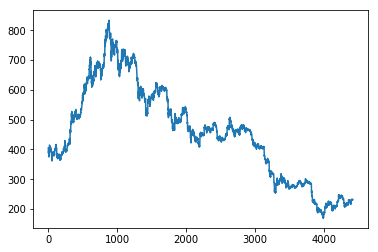

In [8]:
plt.plot(features[:])
plt.show()

In [35]:
config = {
    'exp_name': 'bitcoin_univariate',
    'num_epochs': 2000,
    'learning_rate': 0.0001,
    'batch_size': 64,
    'sequence_length': 20,
    'max_to_keep': 5,
    'test_size': 0.20,
    'num_inputs': 1,
    'num_outputs': 1,
    'rnn_units': [40, 40, 40],
    'lambda_l2_reg': 0.005
}

config_path = 'configs/{}.json'.format(config['exp_name'])

with open(config_path, 'w') as config_file:
    json.dump(config, config_file)

config = process_config(config_path)
if os.path.exists(config.summary_dir):
    shutil.rmtree(config.summary_dir)
create_dirs([config.summary_dir, config.checkpoint_dir])

0

In [36]:
tf.reset_default_graph()

In [37]:
sess = tf.Session()

In [38]:
generator = DataGenerator(config, features, labels)

In [39]:
# model = LSTMModel(config)
model = LSTMModel(config)

In [40]:
logger = Logger(sess, config)

In [41]:
trainer = Trainer(sess, model, generator, config, logger)

In [42]:
trainer.train()

KeyboardInterrupt: 

In [ ]:
evaler = Evaler(sess, model, generator, config)

In [ ]:
train_loss, train_prediction, test_loss, test_prediction = evaler.evaluate()

In [ ]:
train_loss

In [ ]:
plt.plot(generator.data_train)
plt.plot(train_prediction)

In [ ]:
test_loss

In [ ]:
plt.plot(generator.data_test)
plt.plot(test_prediction)

In [ ]:
pred_deltas = np.diff(np.append(generator.data_test.flatten()[:config.sequence_length], test_prediction.flatten()))
real_deltas = np.diff(generator.data_test.flatten())

sum(np.sign(pred_deltas) == np.sign(real_deltas)) / len(real_deltas)

In [ ]:
np.concatenate(generator.data_test, test_prediction)

In [ ]:
a = np.diff(generator.data_test)